In [1]:
import numpy as np
from tqdm import tqdm
import cv2

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ml_exercise_therapanacea.zip to ml_exercise_therapanacea.zip


In [2]:
from zipfile import ZipFile
import os
file_name = "ml_exercise_therapanacea.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

FileNotFoundError: [Errno 2] No such file or directory: 'ml_exercise_therapanacea.zip'

In [3]:
y=[]
#os.chdir('/content')
with open('label_train.txt', 'r') as f:
    y = [int(line.strip()) for line in f.readlines()]
print(f"Total: {len(y)}, Distribution: {np.bincount(y)}")

Total: 100000, Distribution: [12102 87898]


In [6]:
import os
from tqdm import tqdm
import cv2
import re
X=[]
os.chdir('train_img')
def numerical_sort(value):
    # extrait les nombres dans le nom du fichier
    numbers = re.findall(r'\d+', value)
    return int(numbers[0]) if numbers else 0

files = sorted(os.listdir(), key=numerical_sort)

In [7]:
for i in tqdm(files):
      img = cv2.imread(i)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      #img = cv2.resize(img,(224,224))
      X.append(img)

100%|██████████| 100000/100000 [00:20<00:00, 4965.94it/s]


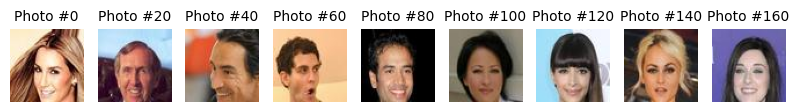

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(1, 9, i+1)
    image_index = i*20
    plt.imshow(X[image_index].astype('uint8'))
    plt.axis('off')
    plt.title(f'Photo #{image_index}', fontsize=10)
plt.show()

In [10]:
import numpy as np
X=np.array(X)
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
le = LabelEncoder()
y=le.fit_transform(y)
y = tf.keras.utils.to_categorical(y, num_classes=2)

In [ ]:
# # Échantillonner
# sample_size = 1000
# sample_indices = np.random.choice(len(y), sample_size, replace=False)
# sample_labels = [y[i] for i in sample_indices]

In [30]:
from sklearn.model_selection import train_test_split
sample_size = 1000
_, sample_indices = train_test_split(
    range(len(y)),
    test_size=sample_size,
    stratify=y,
    random_state=42
)
sample_labels = [y[i] for i in sample_indices]
print(len(sample_labels))
train_indices, val_indices = train_test_split(
    sample_indices,
    test_size=0.2,  # 20% pour le test
    stratify=sample_labels,
    random_state=42
)

# Récupérer les labels finaux
y_train = y[train_indices]
y_val = y[val_indices]
X_train = X[train_indices]
X_val = X[val_indices]

1000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

class_names = ['Classe 0', 'Classe 1']
random_indices = random.sample(range(len(X_train)), 6)

plt.figure(figsize=(18, 8))

for i, idx in enumerate(random_indices):
   # Image via X_train
   plt.subplot(2, 6, i+1)
   plt.imshow(X_train[idx])
   label = np.argmax(y_train[idx])
   original_idx = train_indices[idx]
   plt.title(f'X_train[{idx}]\nOriginal #{original_idx}\n{class_names[label]}', fontsize=9)
   plt.axis('off')

   # Image via X[original_idx] pour vérification
   plt.subplot(2, 6, i+7)
   plt.imshow(X[original_idx])
   label_original = np.argmax(y[original_idx])
   plt.title(f'X[{original_idx}]\nDirect access\n{class_names[label_original]}', fontsize=9)
   plt.axis('off')

plt.suptitle('Vérification: X_train vs X[original_idx]', fontsize=16)
plt.tight_layout()
plt.show()

In [61]:
from keras.applications import vgg16
# Define the input image size (224x224 pixels, 3 color channels)
img_rows, img_cols = 64, 64

# Load the VGG16 model with ImageNet pre-trained weights, excluding the top fully connected layers
vgg = vgg16.VGG16(weights='imagenet',
                  include_top=False,  # Exclude the top layers (we'll add our own)
                  input_shape=(img_rows, img_cols, 3))  # Define the input image shape

# Freeze the layers of the pre-trained VGG16 model so they are not updated during training
# This allows us to use the learned features without modifying them
for layer in vgg.layers:
    layer.trainable = False  # Set each layer's 'trainable' property to False


In [62]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [63]:
from tensorflow.keras.models import Model

num_classes = 2

FC_Head = lw(vgg, num_classes)
model = Model(inputs = vgg.input, outputs = FC_Head)
print(model.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [64]:
from sklearn.utils.class_weight import compute_class_weight
# Convertir les labels one-hot en labels numériques
y_train_labels = np.argmax(y_train, axis=1)

# Calculer les poids basés sur la fréquence
classes = np.unique(y_train_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_labels)
class_weight_dict = dict(zip(classes, class_weights))
print("Distribution des classes:")
print(f"Classe 0: {np.sum(y_train_labels == 0)} échantillons")
print(f"Classe 1: {np.sum(y_train_labels == 1)} échantillons")
print(f"\nPoids calculés:")
print(f"Classe 0: {class_weight_dict[0]:.3f}")
print(f"Classe 1: {class_weight_dict[1]:.3f}")

Distribution des classes:
Classe 0: 97 échantillons
Classe 1: 703 échantillons

Poids calculés:
Classe 0: 4.124
Classe 1: 0.569


In [65]:
# Compile the model with an optimizer and loss function
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
# from tensorflow.keras.optimizers import Adam
# # Learning rate beaucoup plus bas quand on dégèle des couches
# model.compile(optimizer=Adam(learning_rate=0.00001),  # Très bas !
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [66]:
history = model.fit(X_train,y_train,
                    epochs=5,
                    validation_data=(X_val,y_val),
                    verbose = 1,
                    initial_epoch=0,
                    class_weight=class_weight_dict)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 507ms/step - accuracy: 0.5345 - loss: 15.5593 - val_accuracy: 0.8450 - val_loss: 0.6165
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.8381 - loss: 0.4662 - val_accuracy: 0.8250 - val_loss: 0.4219
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.9089 - loss: 0.2420 - val_accuracy: 0.8400 - val_loss: 0.4609
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 505ms/step - accuracy: 0.9396 - loss: 0.1235 - val_accuracy: 0.8250 - val_loss: 0.5273
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.9678 - loss: 0.0823 - val_accuracy: 0.8650 - val_loss: 0.6815


In [67]:
from tensorflow.keras.optimizers import Adam
# Étape 2 : Dégeler et fine-tune avec LR très bas
for layer in vgg.layers[-4:]:
    layer.trainable = True
    
model.compile(optimizer=Adam(learning_rate=0.00001))
# Continuer l'entraînement
history2 = model.fit(X_train, y_train,
                     epochs=3,  # Moins d'epochs pour le fine-tuning
                     validation_data=(X_val, y_val),
                     verbose=1,
                     class_weight=class_weight_dict)

Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 619ms/step - accuracy: 0.9905 - loss: 0.0323 - val_accuracy: 0.8750 - val_loss: 0.7123
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 615ms/step - accuracy: 0.9973 - loss: 0.0084 - val_accuracy: 0.8800 - val_loss: 0.7787
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 610ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.8750 - val_loss: 0.7807


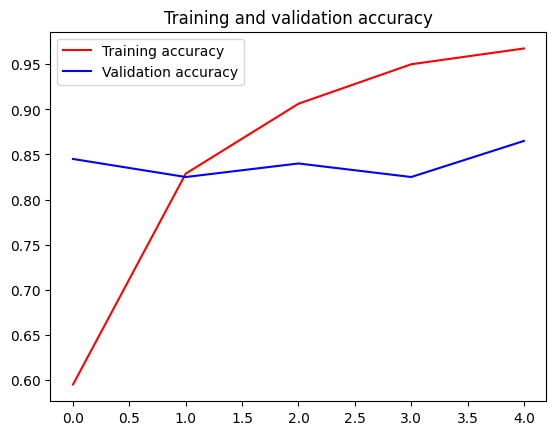

<Figure size 640x480 with 0 Axes>

In [68]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [69]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Prédictions sur validation
y_pred_proba = model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)  # Utiliser y_val au lieu de y2

# Stats simples
print("=== RÉSULTATS VALIDATION ===")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
print(f"\nMatrice de confusion:")
print(f"                 Prédite")
print(f"Vraie    0    1")
print(f"  0     {cm[0,0]}   {cm[0,1]}")
print(f"  1     {cm[1,0]}   {cm[1,1]}")

# Stats par classe
print(f"\nPar classe:")
print(f"Classe 0 - Précision: {cm[0,0]/(cm[0,0]+cm[1,0]):.3f}, Recall: {cm[0,0]/(cm[0,0]+cm[0,1]):.3f}")
print(f"Classe 1 - Précision: {cm[1,1]/(cm[1,1]+cm[0,1]):.3f}, Recall: {cm[1,1]/(cm[1,1]+cm[1,0]):.3f}")

print(f"\nTotal échantillons: {len(y_true)}")
print(f"Bien classés: {cm[0,0] + cm[1,1]}")
print(f"Mal classés: {cm[0,1] + cm[1,0]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step
=== RÉSULTATS VALIDATION ===
Accuracy: 0.8750

Matrice de confusion:
                 Prédite
Vraie    0    1
  0     8   16
  1     9   167

Par classe:
Classe 0 - Précision: 0.471, Recall: 0.333
Classe 1 - Précision: 0.913, Recall: 0.949

Total échantillons: 200
Bien classés: 175
Mal classés: 25
